https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv', 'data_description.txt']


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

color = sns.color_palette()
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x : '{:.3f}'.format(x)) #limiting floats output to 3 decimal points

In [7]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [8]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,CBlock,TA,TA,No,Rec,468.000,LwQ,144.000,270.000,882.000,GasA,TA,Y,SBrkr,896,0,0,896,0.000,0.000,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.000,Unf,1.000,730.000,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.000,TA,TA,CBlock,TA,TA,No,ALQ,923.000,Unf,0.000,406.000,1329.000,GasA,TA,Y,SBrkr,1329,0,0,1329,0.000,0.000,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.000,Unf,1.000,312.000,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,PConc,Gd,TA,No,GLQ,791.000,Unf,0.000,137.000,928.000,GasA,Gd,Y,SBrkr,928,701,0,1629,0.000,0.000,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.000,Fin,2.000,482.000,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.000,TA,TA,PConc,TA,TA,No,GLQ,602.000,Unf,0.000,324.000,926.000,GasA,Ex,Y,SBrkr,926,678,0,1604,0.000,0.000,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.000,Fin,2.000,470.000,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.000,Gd,TA,PConc,Gd,TA,No,ALQ,263.000,Unf,0.000,1017.000,1280.000,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.000,0.000,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.000,RFn,2.000,506.000,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [10]:
print('train shape : ', train.shape)
print('test shape : ', test.shape)

train shape :  (1460, 81)
test shape :  (1459, 80)


In [11]:
train_ID = train['Id']
test_ID = test['Id']

#id column drop
train.drop('Id', axis = 1, inplace=True)
test.drop('Id', axis = 1, inplace = True)

In [12]:
print('train shape : ', train.shape)
print('test shape : ', test.shape)

train shape :  (1460, 80)
test shape :  (1459, 79)


# Data Processing
## Ouliers
공식 문서에서 outlier가 존재한다고 언급함

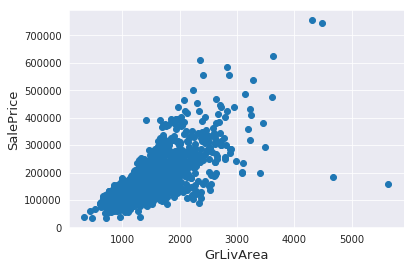

In [13]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize = 13)
plt.xlabel('GrLivArea', fontsize = 13)

plt.show()

bottom right에 두 개의 점이 극단적인 outlier -> 제거~!

In [16]:
outlier_conditions = (train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)
train = train.drop(train[outlier_conditions].index)

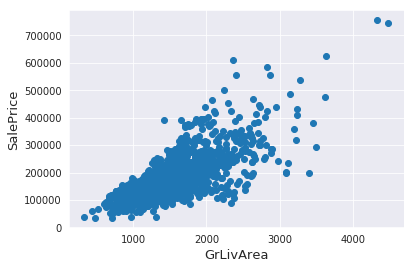

In [18]:
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize = 13)
plt.xlabel('GrLivArea', fontsize = 13)

plt.show()

### Note :
outlier를 제거하는 것이 항상 좋다고 할 수는 없다. train data에 분명 다른 아웃라이어들이 있을 것이다. 하지만, 그것들을 다 제거하는 것은 test data에도 아웃라이어가 포함되어 있을 때, 오히려 더 나쁜 영향을 끼칠 수도 있다. 아웃라이어를 다 제거하는 대신에 우리의 모델을 robust하게 만드는 이유이다.

## Target Variable - SalePrice

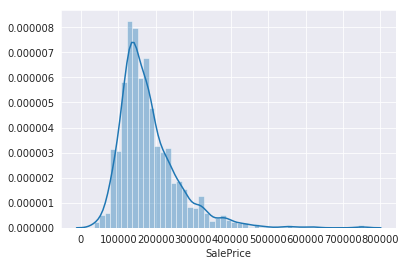

In [22]:
sns.distplot(train['SalePrice'])

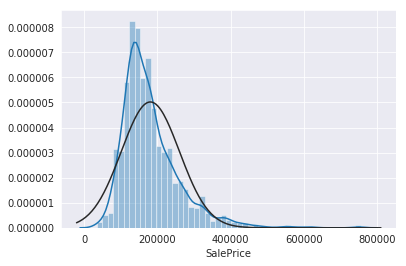

In [21]:
sns.distplot(train['SalePrice'], fit = norm)

In [23]:
from scipy import stats
from scipy.stats import norm, skew

In [25]:
(mu, sigma) = norm.fit(train['SalePrice'])

print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma)) #train['SalePrice'].mean(), train['SalePrice'].std()과 동일


 mu = 180932.92 and sigma = 79467.79



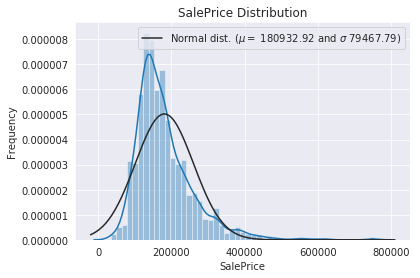

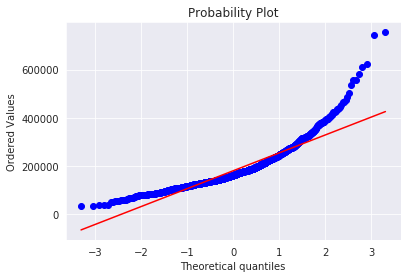

In [30]:
sns.distplot(train['SalePrice'], fit = norm)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma$ {:.2f})'.format(mu, sigma)], loc = 'best')

plt.ylabel('Frequency')
plt.title('SalePrice Distribution')

#Get also QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot = plt)
plt.show()

target value가 skewed to right 되어 있다.- > log transformation

### log transformation of the target variable

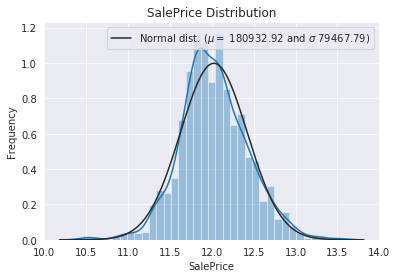

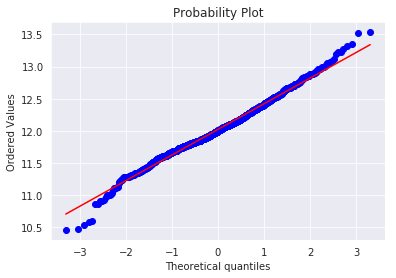

In [31]:
train['SalePrice'] = np.log1p(train['SalePrice'])

sns.distplot(train['SalePrice'], fit = norm)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma$ {:.2f})'.format(mu, sigma)], loc = 'best')

plt.ylabel('Frequency')
plt.title('SalePrice Distribution')

#Get also QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot = plt)
plt.show()

more normally distributed

 ## Feature Engineering

In [33]:
ntrain = train.shape[0]
ntest = test.shape[0]

y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop = True)
all_data.drop(['SalePrice'], axis = 1, inplace = True)
print('all data size : ', all_data.shape)

all data size :  (2917, 79)


### missing data

In [38]:
#NA가 있는 column들 출력
all_data.isnull().sum()[all_data.isnull().sum().values != 0]

Alley           2719
BsmtCond          82
BsmtExposure      82
BsmtFinSF1         1
BsmtFinSF2         1
BsmtFinType1      79
BsmtFinType2      80
BsmtFullBath       2
BsmtHalfBath       2
BsmtQual          81
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
Fence           2346
FireplaceQu     1420
Functional         2
GarageArea         1
GarageCars         1
GarageCond       159
GarageFinish     159
GarageQual       159
GarageType       157
GarageYrBlt      159
KitchenQual        1
LotFrontage      486
MSZoning           4
MasVnrArea        23
MasVnrType        24
MiscFeature     2812
PoolQC          2908
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

In [43]:
print('the number of columns which have NAs : ',len(all_data.isnull().sum()[all_data.isnull().sum().values != 0]))

the number of columns which have NAs :  34


In [44]:
all_data_na = all_data.isnull().sum() / len(all_data) * 100 #NA 비율
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending = False)[:30]

missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageCond,5.451
GarageFinish,5.451
GarageYrBlt,5.451


Text(0.5, 0, 'Percent missing data by feature')

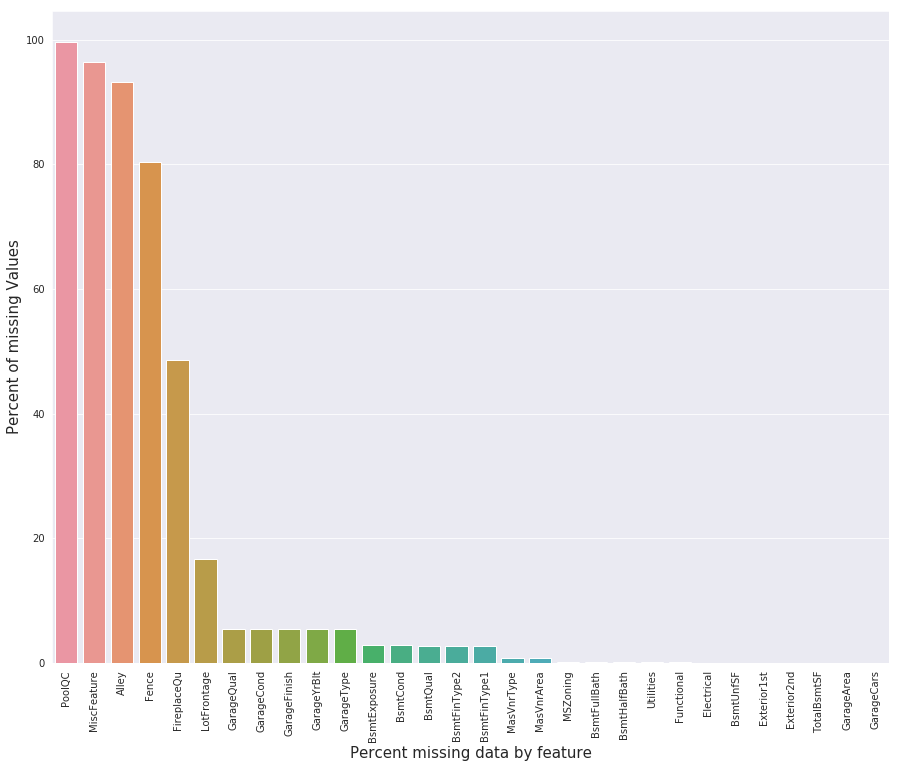

In [45]:
f, ax = plt.subplots(figsize = (15,12))
plt.xticks(rotation = '90')
sns.barplot(x = all_data_na.index, y = all_data_na)

plt.xlabel('Features', fontsize = 15)
plt.ylabel('Percent of missing Values', fontsize = 15)
plt.xlabel('Percent missing data by feature', fontsize = 15)

### Data Correlation

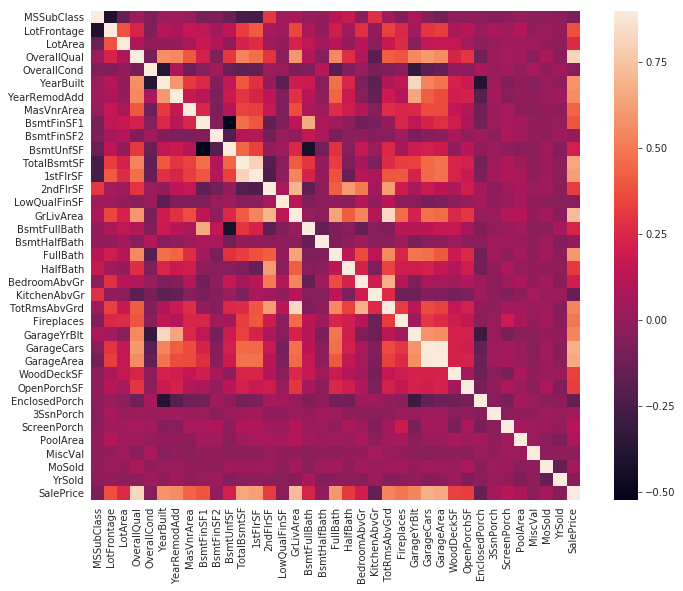

In [47]:
corrmat = train.corr()
plt.subplots(figsize = (12,9))
sns.heatmap(corrmat, vmax = 0.9, square = True)

### imputing missing values

- **PoolQC** : data description에 따르면 NA는 'No Pool'을 의미

In [52]:
all_data.PoolQC.value_counts()

Ex    4
Gd    3
Fa    2
Name: PoolQC, dtype: int64

In [53]:
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

- **MiscFeature ** : data description에 따르면 NA는 'no misc featrure'을 의미

In [54]:
all_data.MiscFeature.value_counts()

Shed    95
Gar2     5
Othr     4
TenC     1
Name: MiscFeature, dtype: int64

In [55]:
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

- **Alley ** : data description에 따르면 NA는 'no misc featrure'을 의미

In [56]:
all_data.Alley.value_counts()

Grvl    120
Pave     78
Name: Alley, dtype: int64

In [57]:
all_data['Alley'] = all_data['Alley'].fillna('None')

- **Fence  ** : data description에 따르면 NA는 'no Fence'을 의미**

In [59]:
all_data.Fence.value_counts()

None     2346
MnPrv     329
GdPrv     118
GdWo      112
MnWw       12
Name: Fence, dtype: int64

In [58]:
all_data['Fence'] = all_data['Fence'].fillna('None')

- **FireplaceQu  ** : data description에 따르면 NA는 'no FireplaceQu'을 의미

In [60]:
all_data.FireplaceQu.value_counts()

Gd    742
TA    592
Fa     74
Po     46
Ex     43
Name: FireplaceQu, dtype: int64

In [61]:
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

- **LogFrontage** : Linear feet of street connected to property(도로까지의 거리?) 따라서 근처에 있는 집들과 비슷할 것이다!neighborhood로 group지어서 median!**

In [63]:
all_data.groupby('Neighborhood')['LotFrontage'].median()

Neighborhood
Blmngtn   43.000
Blueste   24.000
BrDale    21.000
BrkSide   51.000
ClearCr   80.500
CollgCr   70.000
Crawfor   70.000
Edwards   64.500
Gilbert   64.000
IDOTRR    60.000
MeadowV   21.000
Mitchel   74.000
NAmes     73.000
NPkVill   24.000
NWAmes    80.000
NoRidge   89.000
NridgHt   92.000
OldTown   60.000
SWISU     60.000
Sawyer    72.000
SawyerW   67.000
Somerst   72.500
StoneBr   60.000
Timber    82.000
Veenker   80.000
Name: LotFrontage, dtype: float64

In [65]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x : x.fillna(x.median()))

- **GarageType**, **GarageFinish, GarageQual and GarageCond** : Replacing missing data with None

In [66]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond') :
    all_data[col] = all_data[col].fillna('None')

- **GarageYrBlt, GarageArea and GarageCars** : Replacing missing data with 0 (Since No garage = no cars in such garage.)

In [67]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : basement와 관련 있는 칼럼들이 NA인 경우는 지하실이 없다고 간주. none으로 채운다

In [68]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

- **MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.

In [69]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- **MSZoning** (The general zoning classification) : RL이 최빈값 RL로 채운다

In [70]:
all_data['MSZoning'].value_counts()

RL         2263
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [73]:
print(all_data['MSZoning'].mode())
print(all_data['MSZoning'].mode()[0])

0    RL
dtype: object
RL


In [74]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

- **Utilities** : 한 개의 값 빼고는 모두 같은 값으로 들어가 있다. 예측에 유용하지 않을 것 같아 삭제

In [75]:
all_data.Utilities.value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

In [76]:
all_data = all_data.drop(['Utilities'], axis = 1)

- **Functional  ** : data description에 따르면 NA는 'typical'을 의미

In [77]:
all_data.Functional.value_counts()

Typ     2715
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64

In [78]:
all_data['Functional'] = all_data['Functional'].fillna('Typ')

- **Electrical, KitchenQual, Exterior1st and Exterior2nd, SaleType** : 이 데이터 모두 최빈값으로 채워준다.

In [83]:
all_data.columns

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'PoolQC',

In [85]:
for col in ['Electrical','KitchenQual','Exterior2nd','Exterior1st','SaleType'] :
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [86]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

missing value가 있는지 체크!

In [88]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [89]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


### transformation
- numerical variabels that are really categorical

In [90]:
all_data['MSSubClass'].value_counts()

20     1079
60      573
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

In [91]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].apply(str)

#year and month -> categorical
all_data['YrSold'] = all_data['YrSold'].apply(str)
all_data['MoSold'] = all_data['MoSold'].apply(str)

- 순서가 의미가 있는 범주형 변수들은 label encoding

In [92]:
from sklearn.preprocessing import LabelEncoder

In [109]:
len(all_data.dtypes[all_data.dtypes == 'object'].index)

46

In [117]:
cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']

len(cols)

26

In [112]:
for col in cols :
    lbl = LabelEncoder()
    lbl.fit(list(all_data[col].values))
    all_data[col] = lbl.transform(list(all_data[col].values))
    
print('all data shape : ', all_data.shape)

all data shape :  (2917, 78)


In [120]:
all_data[cols].head()

,FireplaceQu,BsmtQual,BsmtCond,GarageQual,GarageCond,ExterQual,ExterCond,HeatingQC,PoolQC,KitchenQual,BsmtFinType1,BsmtFinType2,Functional,Fence,BsmtExposure,GarageFinish,LandSlope,LotShape,PavedDrive,Street,Alley,CentralAir,MSSubClass,OverallCond,YrSold,MoSold
0,3,2,4,5,5,2,4,0,3,2,2,6,6,4,3,2,0,3,2,1,1,1,10,4,2,4
1,5,2,4,5,5,3,4,0,3,3,0,6,6,4,1,2,0,3,2,1,1,1,5,7,1,7
2,5,2,4,5,5,2,4,0,3,2,2,6,6,4,2,2,0,0,2,1,1,1,10,4,2,11
3,2,4,1,5,5,3,4,2,3,2,0,6,6,4,3,3,0,0,2,1,1,1,11,4,0,4
4,5,2,4,5,5,2,4,0,3,2,2,6,6,4,0,2,0,0,2,1,1,1,10,4,2,3


#### add one more important features
- 집의 가용평수 : 지하실 + 1층 + 2층 공간****

In [121]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

#### skewd feature

In [122]:
numeric_feat  = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_feat = all_data[numeric_feat].apply(lambda x : skew(x.dropna())).sort_values(ascending = False)

print('Skew in numerical features')

skewness = pd.DataFrame({'Skew' : skewed_feat})
skewness

Skew in numerical features


,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


일반적으로 skew값이 1보다 크면 왜곡 정도가 높다고 판단

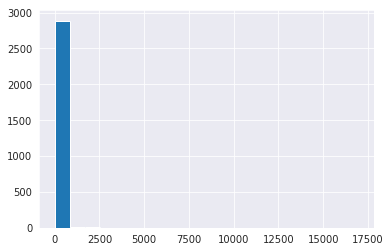

In [123]:
all_data['MiscVal'].hist(bins = 20)

#### Box Cox Transformtion

- $\lambda$ = 0이면, log1p와 동일
- $\lambda$ != 0일 때, ((1+x)**lambda - 1) / lambda

In [125]:
skewness = skewness[abs(skewness) > 0.75] #기준을 0.75로 잡고 0.75보다 크면 변환을 시행

print('there are {} skewed numerical features to Bos-Cox transform'.format(skewness.shape[0]))

there are 59 skewed numerical features to Bos-Cox transform


In [126]:
from scipy.special import boxcox1p

In [127]:
skewed_features = skewness.index

lam = 0.15
for feat in skewed_features :
    all_data[feat] = boxcox1p(all_data[feat], lam)

#### get Dummy 

In [128]:
all_data = pd.get_dummies(all_data)
all_data.shape

(2917, 220)

In [129]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# Modeling

In [130]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

from sklearn.model_selection import KFold, cross_val_score, train_test_split

from sklearn.metrics import mean_squared_error

import xgboost as xgb
import lightgbm as lgb

## Cross - Validation

In [141]:
n_folds = 5

def rmsle_cv(model) :
    kf = KFold(n_folds, shuffle = True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring = 'neg_mean_squared_error', cv = kf))
    
    return rmse

## Base - model
### Bayesian Optimization을 사용하여 tuning

- **Lasso Regression, ElasticNet**은 모두 선형 모형이기 때문에, outlier에 매우 민감! 따라서 robustscaler사용

In [135]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005, random_state = 1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha = 0.0005, l1_ratio=0.9, random_state=3))

- **Kernel Ridge Regression**

In [136]:
KRR = KernelRidge(alpha = 0.6, kernel = 'polynomial', degree = 2, coef0=2.5)

- **Gradient Boosting Regression **: Huber를 loss function으로 사용! 다른 손실함수에 비해 이상치에 대해 민감하지 않다.

In [137]:
GBoost = GradientBoostingRegressor(n_estimators = 3000, learning_rate=0.05, max_depth=4,max_features='sqrt', min_samples_leaf=15, min_samples_split=10,
                                  loss = 'huber', random_state = 5)

- XGBoost

In [138]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

- LightGBM

In [139]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

### Base model scores

In [147]:
base_model = [lasso, ENet, KRR, GBoost, model_xgb, model_lgb]
model_name = ['lasso','ElasticNet', 'Kernel Ridge', 'Gradient Boosting','Xgboost','LightGBM']

for i in range(len(base_model)) :
    score = rmsle_cv(base_model[i])
    print('{0} score : {1:.4f} ({2:.4f})\n'.format(model_name[i], score.mean(), score.std()))

lasso score : 0.1115 (0.0074)

ElasticNet score : 0.1116 (0.0074)

Kernel Ridge score : 0.1153 (0.0075)

Gradient Boosting score : 0.1177 (0.0080)

Xgboost score : 0.1162 (0.0078)

LightGBM score : 0.1162 (0.0071)



# Stacking Models
## Simplest Stacking approach : averageing base models
모델들의 성능을 평균! 클래스로 만들어 코드를 재사용할 수 있도록

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin) :
    
    def __init__(self, models) :
        self.models = models
        
    